# 0. Required Packages

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.1 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.8 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 1. Imports & Utilities

In [ ]:
import pandas as pd
import numpy as np
import os
import gensim

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Bidirectional, Lambda, merge, TimeDistributed, Embedding, Permute, RepeatVector, Activation, Flatten, GRU, Dropout, GaussianNoise, Maximum, Multiply
from keras import backend as K
import keras_tuner as kt

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/HLT Project/"

Mounted at /content/drive


#AraVec Word Embeddings

In [ ]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_100_twitter.zip
!unzip -q full_uni_cbow_100_twitter.zip
!rm full_uni_cbow_100_twitter.zip

--2022-06-07 00:49:55--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_100_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962251835 (918M) [application/zip]
Saving to: ‘full_uni_cbow_100_twitter.zip’

full_uni_cbow_100_t 100%[===================>] 917.67M  13.9MB/s    in 69s     

2022-06-07 00:51:05 (13.2 MB/s) - ‘full_uni_cbow_100_twitter.zip’ saved [962251835/962251835]



In [ ]:
t_model = gensim.models.Word2Vec.load('full_uni_cbow_100_twitter.mdl')

In [ ]:
def getEmbeddingMatrix(word2index, num_tokens, embedding_dim):
  hits = 0
  misses = 0
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2index.items():
    if word in t_model.wv:
        embedding_vector = t_model.wv[ word ]
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
#function to plot accuracy and loss during training
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
def eval_metrics(model, test_tweets_, test_sentiments_):
  predict_probs = model.predict(test_tweets_)
  perdicted_classes=np.argmax(predict_probs,axis=1)
  true_classes=np.argmax(test_sentiments_,axis=1)
  precision = precision_score(true_classes, perdicted_classes, average='macro')
  recall = recall_score(true_classes, perdicted_classes, average='macro')
  f1 = f1_score(true_classes, perdicted_classes, average='macro')
  cm = confusion_matrix(true_classes, perdicted_classes)
  print(classification_report(true_classes,perdicted_classes,labels=[0,1,2]))
  return np.array([[precision, recall, f1, cm]])

In [ ]:
tf.keras.utils.set_random_seed(7)

#2. Getting the Data

##Dataset 1

In [ ]:
#! gdown --id 13O7T4KGfd6yuJYP0cvbZtMJj_8nYaCVX
#dataset = pd.read_pickle('preprocessed_lemmas.pk1')
#! rm preprocessed_lemmas.pk1
! gdown --id 1-4pmYeb9RNgsL4g6o1jKBUDLCPWd37i5
! gdown --id 1-9qpVXoR68jpR3QuZzyIS4MVSWdI5wYz
! gdown --id 19GFJQYAoeQmjQ6a1lms1Traldl_OY_u2
! gdown --id 1-9aXJolDN3z05gP8i23CKofeytH4DDa3
tune1 = pd.read_pickle('tune.pk1')
train1 = pd.read_pickle('train.pk1')
valid1 = pd.read_pickle('valid.pk1')
test1 = pd.read_pickle('test.pk1')
! rm tune.pk1
! rm train.pk1
! rm valid.pk1
! rm test.pk1
print(str(len(tune1))+", " +str(len(train1))+", "+ str(len(valid1))+", " +str(len(test1)))
tune_len = len(tune1)
train_len = len(train1)
valid_len = len(valid1)
dataset1 = tune1.append(train1).append(valid1).append(test1)
dataset1 = dataset1.reset_index(drop=True)
len(dataset1)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-4pmYeb9RNgsL4g6o1jKBUDLCPWd37i5
To: /content/test.pk1
100% 12.3k/12.3k [00:00<00:00, 16.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-9qpVXoR68jpR3QuZzyIS4MVSWdI5wYz
To: /content/train.pk1
100% 87.3k/87.3k [00:00<00:00, 66.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://

671

In [ ]:
tweets = dataset1['tweet']
words1 = set()
max1 = 0
for tweet in tweets:
  if max1 < len(tweet):
    max1 = len(tweet)
  for word in tweet:
    words1.add(word)
sentiments = dataset1.scale.unique()
max1, len(words1), len(sentiments)

(41, 3046, 3)

### Train-Test Split

In [ ]:
#try splitting tweets based on scale
target_column = 'scale'

dataset1[target_column] = dataset1[target_column].astype('category')

#train_split = 0.6
#valtest_split = 0.5
#tune_split = 0.03
#run only once
#dev, tune1 = train_test_split(dataset1, test_size=tune_split, random_state=42, shuffle=True, stratify=dataset1[target_column])
#train1, valtest = train_test_split(dev, test_size=(1.0-train_split), shuffle=True, stratify=dev[target_column])
#valid1, test1 = train_test_split(valtest, test_size=(1.0-valtest_split), shuffle=True, stratify=valtest[target_column])

#output_file_path = os.path.join(base_path, "Data/tune.pk1")
#tune1.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/train.pk1")
#train1.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/valid.pk1")
#valid1.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/test.pk1")
#test1.to_pickle(output_file_path)


tune1 = dataset1[:tune_len]
train1 = dataset1[tune_len:tune_len+train_len]
valid1 = dataset1[tune_len+train_len:tune_len+train_len+valid_len]
test1 = dataset1[tune_len+train_len+valid_len:]
len(tune1), len(train1), len(test1), len(valid1)

(21, 520, 65, 65)

###Checking balance of data

In [ ]:
dataset1['scale'].value_counts()

0     310
1     307
-1     54
Name: scale, dtype: int64

##Dataset 2

In [ ]:
"""
! gdown --id 15_ayY9dQPHCMCfRhS7t6LfSK03yJ_u9P
dataset = pd.read_pickle('astd_preprocessed_lemmas.pk1')
! rm astd_preprocessed_lemmas.pk1
"""
! gdown --id 1-CLWuOFdo_754AEHhrPbP6Uso6dZjCBq
! gdown --id 1-PnehxzfT28Ys7E4mlONVJyfbSRO5uRV
! gdown --id 1-Uystn7PXHXpogKRDo9qlDPesnb9XR4R
! gdown --id 1-LaV0dusSDj32jaLcUnp7o04tENh0GSk
tune2 = pd.read_pickle('astd_tune.pk1')
train2 = pd.read_pickle('astd_train.pk1')
valid2 = pd.read_pickle('astd_valid.pk1')
test2 = pd.read_pickle('astd_test.pk1')
! rm astd_tune.pk1
! rm astd_train.pk1
! rm astd_valid.pk1
! rm astd_test.pk1
print(str(len(tune2))+", " +str(len(train2))+", "+ str(len(valid2))+", " +str(len(test2)))
tune_len = len(tune2)
train_len = len(train2)
valid_len = len(valid2)
dataset2 = tune2.append(train2).append(valid2).append(test2)
dataset2 = dataset2.reset_index(drop=True)

len(dataset2)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-CLWuOFdo_754AEHhrPbP6Uso6dZjCBq
To: /content/astd_test.pk1
100% 84.4k/84.4k [00:00<00:00, 10.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-PnehxzfT28Ys7E4mlONVJyfbSRO5uRV
To: /content/astd_train.pk1
100% 248k/248k [00:00<00:00, 11.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: 

2397

In [ ]:
tweets = dataset2['tweet']
words2 = set()
max2 = 0
for tweet in tweets:
  if max2 < len(tweet):
    max2 = len(tweet)
  for word in tweet:
    words2.add(word)
sentiments = dataset2.scale.unique()
max2, len(words2), len(sentiments)

(59, 7682, 3)

###Checking balance of data

In [ ]:
dataset2['scale'].value_counts()

-1    799
0     799
1     799
Name: scale, dtype: int64

####downsampling the majority

In [ ]:
#run once
"""
zero = dataset2[dataset2['scale']==0].sample(frac=0.5).reset_index(drop=True)
pos = dataset2[dataset2['scale']==1].reset_index(drop=True)
neg = dataset2[dataset2['scale']==-1].reset_index(drop=True)
remove_n = int(len(zero)/2)

dataset2 = zero.append(pos).append(neg).sample(frac=1).reset_index(drop=True)
dataset2['scale'].value_counts()
"""

"\nzero = dataset2[dataset2['scale']==0].sample(frac=0.5).reset_index(drop=True)\npos = dataset2[dataset2['scale']==1].reset_index(drop=True)\nneg = dataset2[dataset2['scale']==-1].reset_index(drop=True)\nremove_n = int(len(zero)/2)\n\ndataset2 = zero.append(pos).append(neg).sample(frac=1).reset_index(drop=True)\ndataset2['scale'].value_counts()\n"

### Train-Test Split

In [ ]:
#try splitting tweets based on scale
target_column = 'scale'

dataset2[target_column] = dataset2[target_column].astype('category')

train_split = 0.6
valtest_split = 0.5
tune_split = 0.03
#run only once
"""
dev, tune2 = train_test_split(dataset2, test_size=tune_split, random_state=42, shuffle=True, stratify=dataset2[target_column])
train2, valtest = train_test_split(dev, test_size=(1.0-train_split), shuffle=True, stratify=dev[target_column])
valid2, test2 = train_test_split(valtest, test_size=(1.0-valtest_split), shuffle=True, stratify=valtest[target_column])

output_file_path = os.path.join(base_path, "Data/astd_tune.pk1")
tune2.to_pickle(output_file_path)
output_file_path = os.path.join(base_path, "Data/astd_train.pk1")
train2.to_pickle(output_file_path)
output_file_path = os.path.join(base_path, "Data/astd_valid.pk1")
valid2.to_pickle(output_file_path)
output_file_path = os.path.join(base_path, "Data/astd_test.pk1")
test2.to_pickle(output_file_path)

"""
tune2 = dataset2[:tune_len]
train2 = dataset2[tune_len:tune_len+train_len]
valid2 = dataset2[tune_len+train_len:tune_len+train_len+valid_len]
test2 = dataset2[tune_len+train_len+valid_len:]

len(tune2), len(train2), len(test2), len(valid2)

(72, 1395, 465, 465)

##Combined Dataset

In [ ]:
train = train1.append(train2).reset_index(drop=True)
tune = tune1.append(tune2).reset_index(drop=True)
valid = valid1.append(valid2).reset_index(drop=True)
test = test1.append(test2).reset_index(drop=True)
len(train), len(valid), len(test), len(tune)

(1915, 530, 530, 93)

In [ ]:
train['scale'].value_counts(), valid['scale'].value_counts(), test['scale'].value_counts(), tune['scale'].value_counts()

(1     711
 0     701
 -1    503
 Name: scale, dtype: int64, 1     186
 0     183
 -1    161
 Name: scale, dtype: int64, 0     189
 1     179
 -1    162
 Name: scale, dtype: int64, 0     36
 1     30
 -1    27
 Name: scale, dtype: int64)

In [ ]:
max = min(max1, max2)
words = words1.union(words2)
max, len(words)

(41, 9110)

#3. Prepare the Data for the Neural Network

In [ ]:
word2index = {w: i+1 for i, w in enumerate(words)}
tune_tweets = [ [word2index.get(w) for w in s] for s in tune['tweet']]
train_tweets = [ [word2index.get(w) for w in s] for s in train['tweet']]
valid_tweets = [ [word2index.get(w) for w in s] for s in valid['tweet']]
test_tweets = [ [word2index.get(w) for w in s] for s in test['tweet']]

#semeval only
test_tweets1 = [ [word2index.get(w) for w in s] for s in test1['tweet']]


tune_tweets = pad_sequences(tune_tweets, padding='post',maxlen=max, truncating='post')
train_tweets = pad_sequences(train_tweets, padding='post', maxlen=max, truncating='post')
valid_tweets = pad_sequences(valid_tweets, padding='post', maxlen=max, truncating='post')
test_tweets = pad_sequences(test_tweets, padding='post', maxlen=max, truncating='post')
test_tweets1 = pad_sequences(test_tweets1, padding='post', maxlen=max, truncating='post')

tune_sentiments = [sentiment for sentiment in tune['scale']]
tune_sentiments = to_categorical(np.array(tune_sentiments), len(sentiments))
train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))
test_sentiments1 = [sentiment for sentiment in test1['scale']]
test_sentiments1 = to_categorical(np.array(test_sentiments1), len(sentiments))

#4.2 LSTM Model

##Hyperparameter optimization

In [ ]:
embedding_matrix = getEmbeddingMatrix(word2index, len(word2index)+1, 100)
def define_model(hp):
  model = Sequential()
  model.add(Embedding(input_dim=len(word2index)+1, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_length=max, mask_zero=True))
  model.add(GaussianNoise(hp.Float('noise', 0.2, 0.8, step=0.1, default=0.5)))
  for i in range(hp.Int('lstm_blocks', 1, 3, default=1)):
    model.add(Bidirectional(LSTM(
        hp.Choice('rnn_hidden_units_'+str(i), [32, 64, 128, 256]),
        kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal']),
        return_sequences=True)))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.8, step=0.1, default=0.5)))
  model.add(Flatten())
  for i in range(hp.Int('dense_blocks', 1, 3, default=1)):
    model.add(Dense(hp.Choice('dense_hidden_units_'+str(i), [8,16,32,64,128]),
                    activation=hp.Choice('activation', ['relu','sigmoid', 'elu']),
                    kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal'])))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.8, step=0.1, default=0.5)))
  
  model.add(Dense(len(sentiments), kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal']),
                  activation='softmax', activity_regularizer=regularizers.l2(hp.Choice('l2', [0.1,0.01,0.001,0.0001]))))

  opt = tf.keras.optimizers.Adam(
      clipnorm=hp.Choice('clipnorm', [1,2,3,4,5]),
      learning_rate=hp.Float('learning_rate', 5e-5, 5e-1, sampling='log'),
      name='Adam')

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  return model

Converted 6057 words (3053 misses)


In [ ]:
tuner = kt.Hyperband(
    define_model,
    objective='val_categorical_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(tune_tweets,
             tune_sentiments,
             validation_split=0.2,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 180 Complete [00h 00m 27s]
val_accuracy: 0.42105263471603394

Best val_accuracy So Far: 0.5789473652839661
Total elapsed time: 01h 15m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
noise: 0.30000000000000004
lstm_blocks: 3
rnn_hidden_units_0: 32
init: uniform
dropout: 0.8000000000000003
dense_blocks: 1
dense_hidden_units_0: 8
activation: relu
l2: 0.001
clipnorm: 1
learning_rate: 0.0004537900596979063
rnn_hidden_units_1: 256
dense_hidden_units_1: 32
dense_hidden_units_2: 16
rnn_hidden_units_2: 256
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.5789473652839661
Trial summary
Hyperparameters:
noise: 0.7000000000000002
lstm_blocks: 1
rnn_hidden_units_0: 256
init: orthogonal
dropout: 0.7000000000000002
dense_blocks: 2
dense_hidden_units_0: 32
activation: relu
l2: 0.1
clipnorm: 4
learning_rate: 0.025239055498126044
rnn_hidden_units_1: 64
dense_hidden_units_1: 32
dense_hidden_units_2: 16
rnn_hidden_units_2: 256
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0053
Score: 0.5263158082962036
Trial summa

##Training the Model

In [ ]:
#set hyperparameters to best ones obtained via grid search
EPOCHS = 1000
BATCH_SIZE = 32
model = tuner.get_best_models()[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 100)           911100    
                                                                 
 gaussian_noise (GaussianNoi  (None, 41, 100)          0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 41, 64)           34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 41, 512)          657408    
 nal)                                                            
                                                        

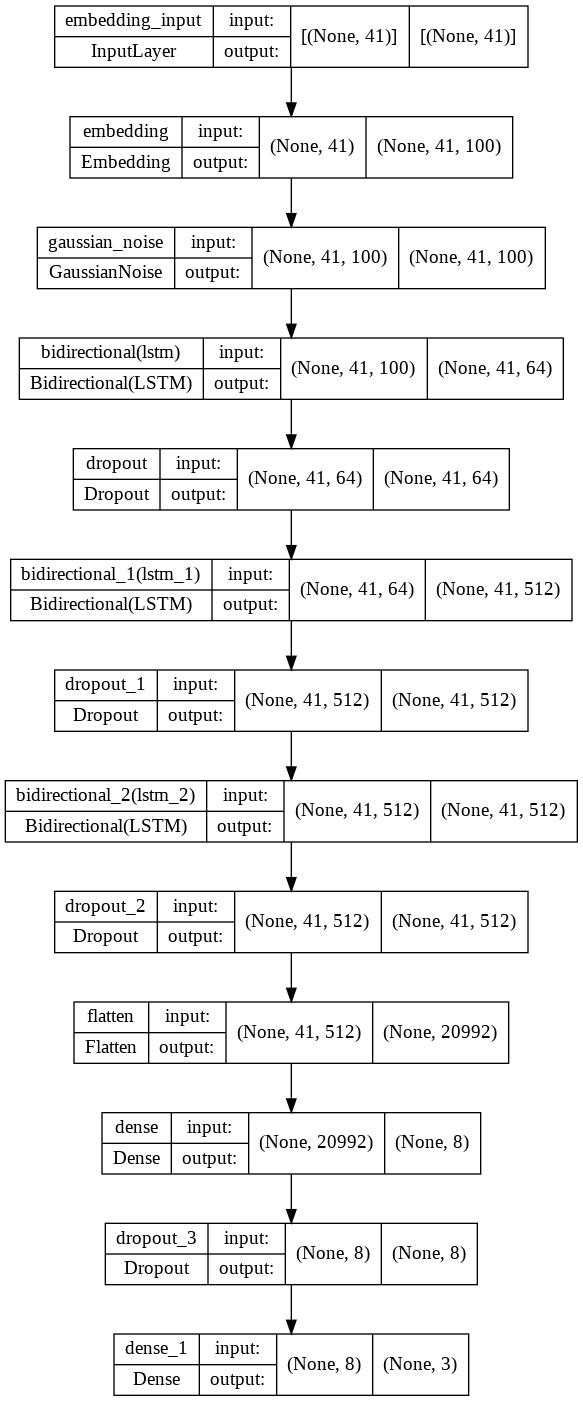

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_categorical_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20
)

history = model.fit(train_tweets,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(valid_tweets,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/1000
60/60 [==============================] - 30s 155ms/step - loss: 1.0974 - categorical_accuracy: 0.3697 - val_loss: 1.0963 - val_categorical_accuracy: 0.3585
Epoch 2/1000
60/60 [==============================] - 3s 46ms/step - loss: 1.0919 - categorical_accuracy: 0.3906 - val_loss: 1.0516 - val_categorical_accuracy: 0.4698
Epoch 3/1000
60/60 [==============================] - 3s 44ms/step - loss: 1.0471 - categorical_accuracy: 0.4115 - val_loss: 1.0289 - val_categorical_accuracy: 0.4585
Epoch 4/1000
60/60 [==============================] - 3s 45ms/step - loss: 1.0327 - categorical_accuracy: 0.4360 - val_loss: 1.0253 - val_categorical_accuracy: 0.4868
Epoch 5/1000
60/60 [==============================] - 3s 47ms/step - loss: 1.0274 - categorical_accuracy: 0.4413 - val_loss: 1.0206 - val_categorical_accuracy: 0.4943
Epoch 6/1000
60/60 [==============================] - 3s 48ms/step - loss: 1.0120 - categorical_accuracy: 0.4507 - val_loss: 1.0043 - val_categorical_accuracy: 0.5

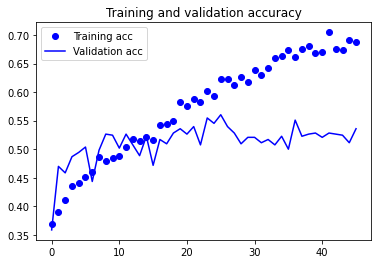

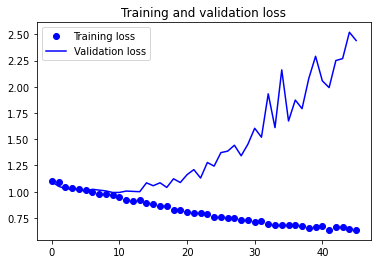

In [ ]:
plot(history)

###Save the Model

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(train_tweets, train_sentiments)
train_accuracy

60/60 [==============================] - 1s 13ms/step - loss: 0.4698 - categorical_accuracy: 0.8621


0.8621410131454468

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_tweets, valid_sentiments)
valid_accuracy

17/17 [==============================] - 0s 15ms/step - loss: 1.3726 - categorical_accuracy: 0.5604


0.5603773593902588

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, test_sentiments)
test_accuracy

17/17 [==============================] - 0s 15ms/step - loss: 1.3826 - categorical_accuracy: 0.5208


0.5207546949386597

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, test_tweets, test_sentiments), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       189
           1       0.55      0.58      0.57       179
           2       0.59      0.49      0.53       162

    accuracy                           0.52       530
   macro avg       0.53      0.52      0.52       530
weighted avg       0.53      0.52      0.52       530

  precision    recall        F1  CM
-----------  --------  --------  ---------------
   0.529953  0.520241  0.523018  [[ 93  54  42]
                                  [ 62 104  13]
                                  [ 53  30  79]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#just on semeval test
test_loss, test_accuracy = model.evaluate(test_tweets1, test_sentiments1)
test_accuracy

3/3 [==============================] - 0s 41ms/step - loss: 1.1627 - categorical_accuracy: 0.6154


0.6153846383094788

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, test_tweets1, test_sentiments1), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           0       0.67      0.59      0.62        34
           1       0.59      0.71      0.64        24
           2       0.50      0.43      0.46         7

    accuracy                           0.62        65
   macro avg       0.58      0.58      0.58        65
weighted avg       0.62      0.62      0.61        65

  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.584291  0.575047  0.576016  [[20 12  2]
                                  [ 6 17  1]
                                  [ 4  0  3]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
model.save('astd_bi_2_LSTM_comb.h5')

In [ ]:
output_file_path = os.path.join(base_path, "Models/astd_bi_2_LSTM_comb.h5")
model.save(output_file_path)

#4.3 LSTM + CNN

##Hyperparameter Tuning

In [ ]:
embedding_matrix = getEmbeddingMatrix(word2index, len(word2index)+1, 100)

def define_lstm_cnn_model(hp):
  model = Sequential()
  model.add(Embedding(input_dim=len(word2index)+1, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_length=max, mask_zero=True))
  model.add(GaussianNoise(hp.Float('noise', 0.2, 0.8, step=0.1, default=0.5)))
  
  for i in range(hp.Int('lstm_blocks', 1, 3, default=1)):
    model.add(Bidirectional(LSTM(
        hp.Choice('rnn_hidden_units_'+str(i), [32, 64, 128, 256]),
        kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal']),
        return_sequences=True)))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.8, step=0.1, default=0.5)))

  for i in range(hp.Int('conv_blocks', 1, 2, default=1)):
    k=hp.Choice('filter_size_'+str(i), [3, 5, 7])
    p = [3,5] if k == 7 else [3] if k == 5 else [2]
    model.add(tf.keras.layers.Conv1D(hp.Choice('conv_filters_'+str(i), [32, 64, 128, 256]),
                                     k,
                                     kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal']),
                                     activation=hp.Choice('activation', ['relu','sigmoid', 'elu']),
                                     padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=hp.Choice('pool_size_'+str(i), p)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0.2, 0.8, step=0.1, default=0.5)))

  for i in range(hp.Int('dense_blocks', 1, 3, default=1)):
    model.add(Dense(hp.Choice('dense_hidden_units_'+str(i), [8,16,32,64,128]),
                    activation=hp.Choice('activation', ['relu','sigmoid', 'elu']),
                    kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal'])))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.8, step=0.1, default=0.5)))
    
  model.add(Flatten())
  model.add(Dense(len(sentiments), kernel_initializer=hp.Choice('init' , ['random_uniform', 'uniform', 'orthogonal']),
                  activation='softmax', activity_regularizer=regularizers.l2(hp.Choice('l2', [0.1,0.01,0.001,0.0001]))))

  opt = tf.keras.optimizers.Adam(
      clipnorm=hp.Choice('clipnorm', [1,2,3,4,5]),
      learning_rate=hp.Float('learning_rate', 5e-5, 5e-1, sampling='log'),
      name='Adam')
  
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

Converted 6056 words (3054 misses)


In [ ]:
tuner = kt.Hyperband(
    define_lstm_cnn_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(tune_tweets,
             tune_sentiments,
             validation_split=0.2,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 180 Complete [00h 00m 13s]
val_accuracy: 0.42105263471603394

Best val_accuracy So Far: 0.6315789222717285
Total elapsed time: 01h 13m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
noise: 0.30000000000000004
lstm_blocks: 2
rnn_hidden_units_0: 256
init: orthogonal
dropout: 0.4000000000000001
conv_blocks: 2
filter_size_0: 5
conv_filters_0: 64
activation: elu
pool_size_0: 2
dense_blocks: 3
dense_hidden_units_0: 32
l2: 0.001
clipnorm: 1
learning_rate: 0.007480629126404392
rnn_hidden_units_1: 256
dense_hidden_units_1: 64
rnn_hidden_units_2: 32
filter_size_1: 5
conv_filters_1: 64
pool_size_1: 2
dense_hidden_units_2: 8
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.6315789222717285
Trial summary
Hyperparameters:
noise: 0.5000000000000001
lstm_blocks: 2
rnn_hidden_units_0: 128
init: random_uniform
dropout: 0.6000000000000001
conv_blocks: 1
filter_size_0: 3
conv_filters_0: 32
activation: relu
pool_size_0: 2
dense_blocks: 1
dense_hidden_units_0: 64
l2: 0.001
clipnorm: 4
learning_rate: 0.1351527832953707
rnn_hidden_units_1: 64
dense_hidden_uni

##Training the Model

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 32
model = tuner.get_best_models()[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 100)           911100    
                                                                 
 gaussian_noise (GaussianNoi  (None, 41, 100)          0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 41, 512)          731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 41, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 41, 512)          1574912   
 nal)                                                            
                                                        

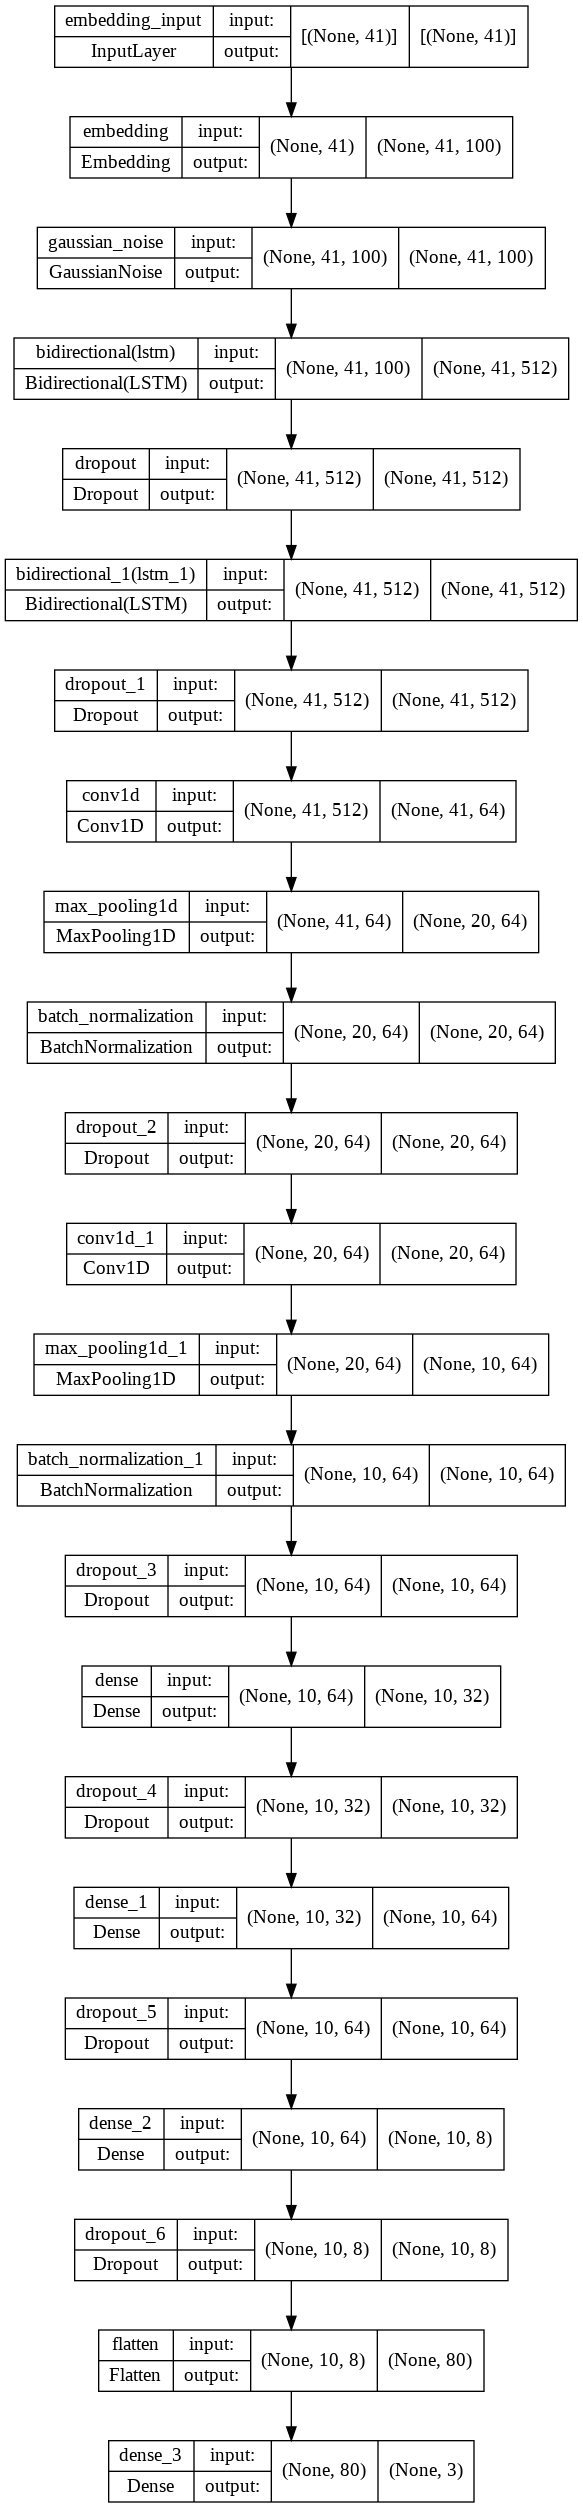

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25
)

history = model.fit(train_tweets,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(valid_tweets,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Converted 6057 words (3053 misses)
Epoch 1/1000
60/60 [==============================] - 25s 123ms/step - loss: 1.1911 - accuracy: 0.3483 - val_loss: 1.0999 - val_accuracy: 0.3528
Epoch 2/1000
60/60 [==============================] - 2s 39ms/step - loss: 1.0887 - accuracy: 0.4162 - val_loss: 1.0742 - val_accuracy: 0.4075
Epoch 3/1000
60/60 [==============================] - 2s 41ms/step - loss: 1.0118 - accuracy: 0.4616 - val_loss: 1.0292 - val_accuracy: 0.4962
Epoch 4/1000
60/60 [==============================] - 2s 40ms/step - loss: 0.8757 - accuracy: 0.5624 - val_loss: 0.9713 - val_accuracy: 0.5132
Epoch 5/1000
60/60 [==============================] - 2s 39ms/step - loss: 0.7008 - accuracy: 0.6992 - val_loss: 1.0890 - val_accuracy: 0.5358
Epoch 6/1000
60/60 [==============================] - 2s 40ms/step - loss: 0.5727 - accuracy: 0.7593 - val_loss: 1.4562 - val_accuracy: 0.5472
Epoch 7/1000
60/60 [==============================] - 2s 37ms/step - loss: 0.4439 - accuracy: 0.8366 - va

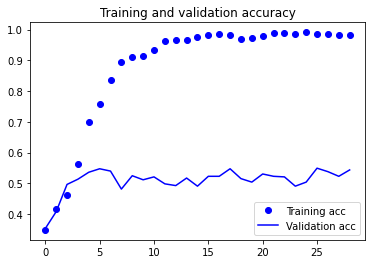

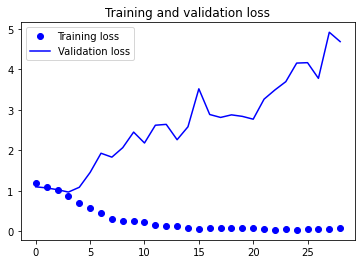

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(train_tweets, train_sentiments)
train_accuracy

60/60 [==============================] - 1s 13ms/step - loss: 0.0113 - accuracy: 0.9979


0.9979112148284912

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_tweets, valid_sentiments)
valid_accuracy

17/17 [==============================] - 0s 14ms/step - loss: 4.1654 - accuracy: 0.5491


0.5490565896034241

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, test_sentiments)
test_accuracy

17/17 [==============================] - 0s 14ms/step - loss: 4.3133 - accuracy: 0.5245


0.5245283246040344

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, test_tweets, test_sentiments), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           1       0.64      0.44      0.52       179
           0       0.43      0.60      0.50       189
          -1       0.00      0.00      0.00         0

   micro avg       0.50      0.52      0.51       368
   macro avg       0.36      0.35      0.34       368
weighted avg       0.54      0.52      0.51       368

  precision    recall        F1  CM
-----------  --------  --------  ---------------
   0.556517  0.523264  0.527857  [[114  32  43]
                                  [ 85  78  16]
                                  [ 65  11  86]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
#just on semeval test
test_loss, test_accuracy = model.evaluate(test_tweets1, test_sentiments1)
test_accuracy

3/3 [==============================] - 0s 14ms/step - loss: 3.3192 - accuracy: 0.6308


0.6307692527770996

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, test_tweets1, test_sentiments1), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           1       0.64      0.58      0.61        24
           0       0.62      0.74      0.68        34
          -1       0.00      0.00      0.00         0

   micro avg       0.63      0.67      0.65        58
   macro avg       0.42      0.44      0.43        58
weighted avg       0.63      0.67      0.65        58

  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.642677  0.534781  0.561457  [[25  8  1]
                                  [10 14  0]
                                  [ 5  0  2]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
output_file_path = os.path.join(base_path, "Models/astd_bi_LSTM_CNN_comb_60.h5")
model.save(output_file_path)

# 4.4 Transformer



##Preparing Data for Transformer

In [ ]:
max = max1 if max1>max2 else max2 

In [ ]:
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
#base or mini
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
bert_model = TFAutoModel.from_pretrained("asafaya/bert-base-arabic")
#bert_model = TFAutoModelForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels=3)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

Some layers from the model checkpoint at asafaya/bert-base-arabic were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at asafaya/bert-base-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
tune_tweets = tokenizer(text=tune['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

train_tweets = tokenizer(text=train['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

valid_tweets = tokenizer(text=valid['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

test_tweets = tokenizer(text=test['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

test_tweets1 = tokenizer(text=test1['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
tune_sentiments = [sentiment for sentiment in tune['scale']]
tune_sentiments = to_categorical(np.array(tune_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))
test_sentiments1 = [sentiment for sentiment in test1['scale']]
test_sentiments1 = to_categorical(np.array(test_sentiments1), len(sentiments))

##Hyperparameter Tuning

In [ ]:
def define_transformer_model(hp):
  input = Input(shape=(2,max), dtype=tf.int32)
  embeddings = bert_model(input_ids=tf.convert_to_tensor(input[:,0],dtype=tf.int32), attention_mask=tf.convert_to_tensor(input[:,1], dtype=tf.int32))[0]
  embeddings=Flatten()(embeddings)

  out = Dropout((hp.Choice('dropout', [0.5, 0.8])))(embeddings)

  out = Dense(hp.Choice('dense_hidden_units2', [8, 128]),
                    activation=hp.Choice('activation', ['elu', 'relu']),
                    kernel_initializer=hp.Choice('init' , ['uniform', 'orthogonal', 'random_uniform']))(out)

  out = Dropout((hp.Choice('dropout', [0.5, 0.8])))(embeddings)
  
  output = Dense(len(sentiments), kernel_initializer=hp.Choice('init' , ['uniform', 'orthogonal', 'random_uniform']),
                  activation='softmax', activity_regularizer=regularizers.l2(hp.Choice('l2', [0.01, 0.001])))(out)
  
  model = tf.keras.Model(inputs=input, outputs=output)
  model.layers[1].trainable=True

  opt = tf.keras.optimizers.Adam(
      clipnorm=hp.Choice('clipnorm', [1,3,5]),
      learning_rate=hp.Choice('lr', [5e-05,5e-06,5e-04,5e-03]),
      name='Adam')
  loss = tf.keras.losses.CategoricalCrossentropy()
  model.compile(loss=loss,
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

In [ ]:
combi_input = np.stack([ tune_tweets['input_ids'], tune_tweets['attention_mask'] ], axis=1)

In [ ]:
tuner = kt.Hyperband(
    define_transformer_model,
    objective='val_categorical_accuracy',
    max_epochs=10,
    hyperband_iterations=1,
    overwrite=True)

tuner.search(combi_input,
             tune_sentiments,
             validation_split=0.2,
             batch_size=32,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 19 Complete [00h 00m 34s]
val_accuracy: 0.42105263471603394

Best val_accuracy So Far: 0.4736842215061188
Total elapsed time: 00h 11m 13s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
0.5               |0.8               |dropout
8                 |128               |dense_hidden_units2
elu               |relu              |activation
uniform           |uniform           |init
0.001             |0.01              |l2
5                 |1                 |clipnorm
0.0005            |5e-06             |lr
4                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/4


KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.8
dense_hidden_units2: 128
activation: relu
init: uniform
l2: 0.01
clipnorm: 1
lr: 5e-06
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.4736842215061188
Trial summary
Hyperparameters:
dropout: 0.8
dense_hidden_units2: 8
activation: elu
init: uniform
l2: 0.01
clipnorm: 5
lr: 5e-05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.42105263471603394
Trial summary
Hyperparameters:
dropout: 0.5
dense_hidden_units2: 128
activation: relu
init: uniform
l2: 0.001
clipnorm: 5
lr: 0.005
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.42105263471603394
Trial summary
Hyperparameters:
dropout: 0.5
dense_hidden_units2: 8
activation: elu
init: orthogonal
l2: 0.01
clipnorm: 3
lr: 0.005
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.42105263471603394
Trial summary
Hype

##Training the model

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 32
model = tuner.get_best_models()[0]


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 59)]      0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 59)          0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 59)          0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                            

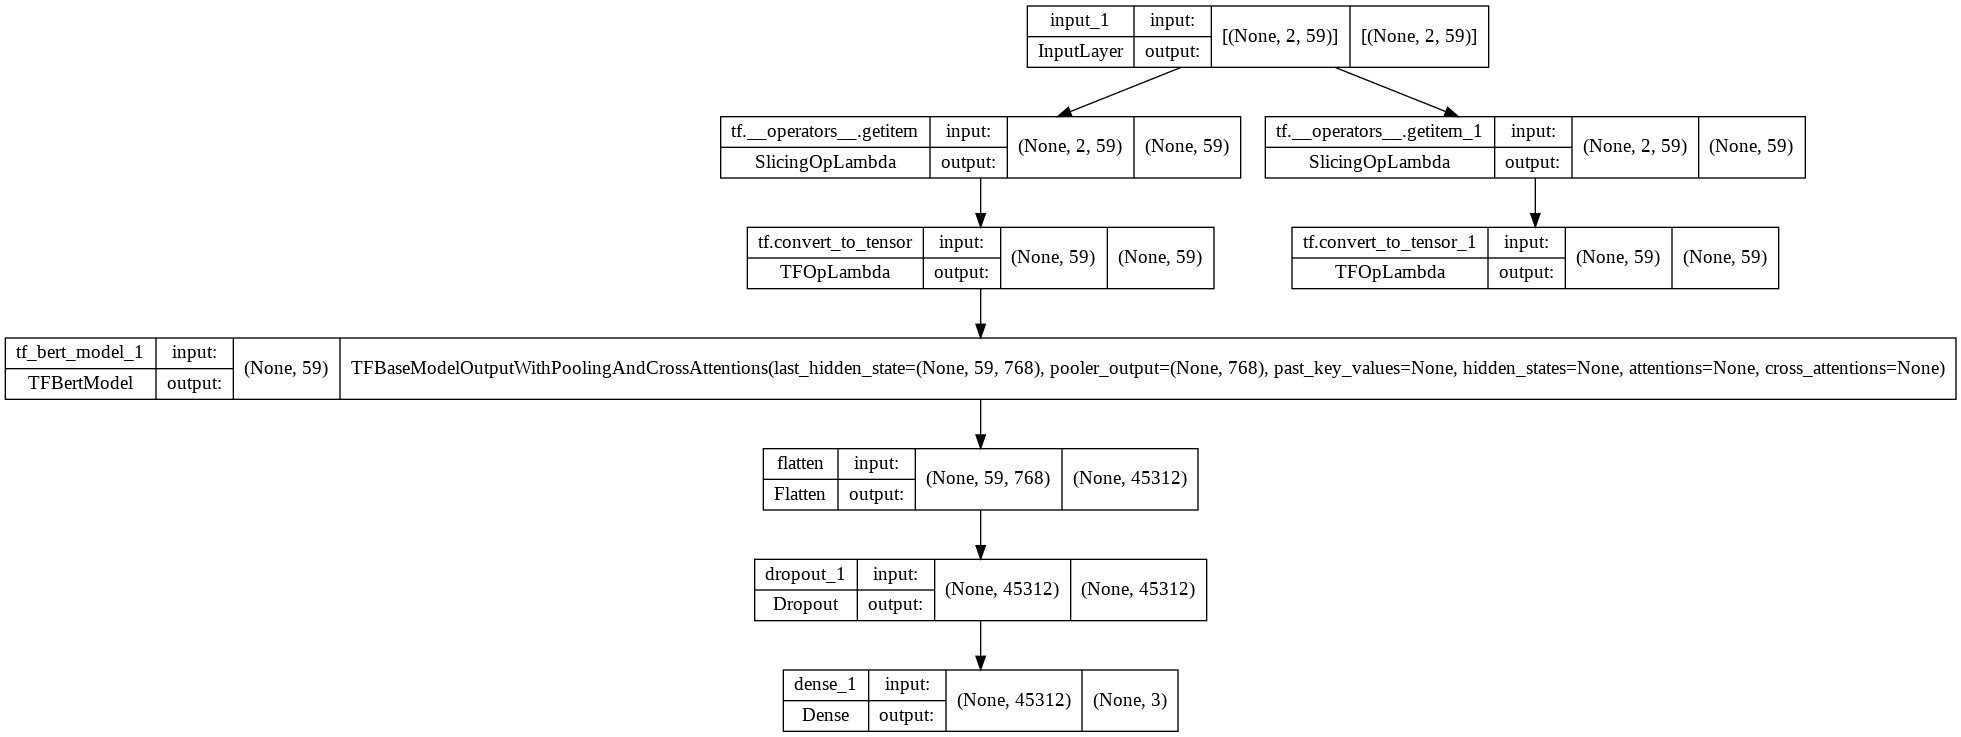

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_categorical_accuracy',
  mode='max',
  save_best_only=True
)

combi_train = np.stack([ train_tweets['input_ids'], train_tweets['attention_mask'] ], axis=1)
combi_valid = np.stack([ valid_tweets['input_ids'], valid_tweets['attention_mask'] ], axis=1)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25
)

history = model.fit(combi_train,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(combi_valid,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/1000
60/60 [==============================] - 57s 606ms/step - loss: 8.0935 - categorical_accuracy: 0.3426 - val_loss: 2.5647 - val_categorical_accuracy: 0.4019
Epoch 2/1000
60/60 [==============================] - 33s 559ms/step - loss: 7.5007 - categorical_accuracy: 0.3608 - val_loss: 2.6100 - val_categorical_accuracy: 0.4170
Epoch 3/1000
60/60 [==============================] - 33s 546ms/step - loss: 6.7420 - categorical_accuracy: 0.3990 - val_loss: 2.3034 - val_categorical_accuracy: 0.4396
Epoch 4/1000
60/60 [==============================] - 33s 548ms/step - loss: 6.9389 - categorical_accuracy: 0.3963 - val_loss: 2.1680 - val_categorical_accuracy: 0.4925
Epoch 5/1000
60/60 [==============================] - 27s 452ms/step - loss: 6.2243 - categorical_accuracy: 0.4334 - val_loss: 2.0973 - val_categorical_accuracy: 0.4925
Epoch 6/1000
60/60 [==============================] - 33s 548ms/step - loss: 5.7197 - categorical_accuracy: 0.4684 - val_loss: 2.1875 - val_categorical_acc

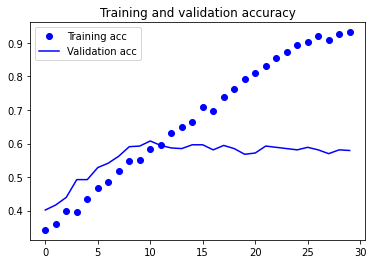

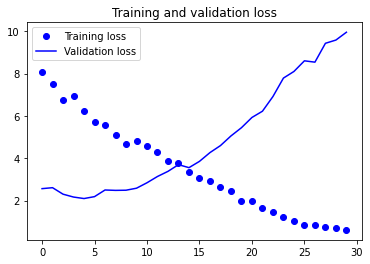

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(combi_train, train_sentiments)
train_accuracy

60/60 [==============================] - 9s 141ms/step - loss: 1.2821 - categorical_accuracy: 0.7640


0.7639686465263367

In [ ]:
valid_loss, valid_accuracy = model.evaluate(combi_valid, valid_sentiments)
valid_accuracy

17/17 [==============================] - 2s 136ms/step - loss: 2.8426 - categorical_accuracy: 0.6075


0.6075471639633179

In [ ]:
combi_test = np.stack([ test_tweets['input_ids'], test_tweets['attention_mask'] ], axis=1)

test_loss, test_accuracy = model.evaluate(combi_test, test_sentiments)
test_accuracy

17/17 [==============================] - 2s 137ms/step - loss: 2.9274 - categorical_accuracy: 0.5943


0.5943396091461182

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, combi_test, test_sentiments), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           0       0.54      0.38      0.45       189
           1       0.63      0.78      0.69       179
           2       0.59      0.64      0.62       162

    accuracy                           0.59       530
   macro avg       0.59      0.60      0.59       530
weighted avg       0.59      0.59      0.58       530

  precision    recall        F1  CM
-----------  --------  --------  ---------------
   0.587255  0.599821  0.585894  [[ 72  61  56]
                                  [ 25 139  15]
                                  [ 36  22 104]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#just on semeval test
combi_test1 = np.stack([ test_tweets1['input_ids'], test_tweets1['attention_mask'] ], axis=1)

test_loss, test_accuracy = model.evaluate(combi_test1, test_sentiments1)
test_accuracy

3/3 [==============================] - 0s 86ms/step - loss: 2.7688 - categorical_accuracy: 0.5538


0.5538461804389954

In [ ]:
from tabulate import tabulate
print(tabulate(eval_metrics(model, combi_test1, test_sentiments1), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           0       0.62      0.38      0.47        34
           1       0.54      0.83      0.66        24
           2       0.43      0.43      0.43         7

    accuracy                           0.55        65
   macro avg       0.53      0.55      0.52        65
weighted avg       0.57      0.55      0.54        65

  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.529387  0.548086  0.519012  [[13 17  4]
                                  [ 4 20  0]
                                  [ 4  0  3]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
model.save('astd_bert_comb.h5')

In [ ]:
output_file_path = 'astd_bert_overfit_comb.h5' #os.path.join(base_path, "Models/astd_bert_overfit_comb.h5")
model.save(output_file_path)

##only for loading transformer

In [ ]:
def define_transformer_model():
  input = Input(shape=(2,max), dtype=tf.int32)
  embeddings = bert_model(input_ids=tf.convert_to_tensor(input[:,0],dtype=tf.int32), attention_mask=tf.convert_to_tensor(input[:,1], dtype=tf.int32))[0]
  embeddings=Flatten()(embeddings)

  out = Dropout((0.8))(embeddings)

  out = Dense(128,activation='relu', kernel_initializer='uniform')(out)

  out = Dropout((0.8))(embeddings)
  
  output = Dense(len(sentiments), kernel_initializer='uniform',
                  activation='softmax', activity_regularizer=regularizers.l2(0.01))(out)
  
  model = tf.keras.Model(inputs=input, outputs=output)
  model.layers[1].trainable=True

  opt = tf.keras.optimizers.Adam(
      clipnorm=1,
      learning_rate=5e-06,
      name='Adam')
  
  loss = tf.keras.losses.CategoricalCrossentropy()
  model.compile(loss=loss,
                optimizer=opt,
                metrics=['categorical_accuracy'])
  return model


  

In [ ]:
model1 = define_transformer_model()

In [ ]:
output_file_path = 'astd_bert_overfit_comb.h5'
model1.load_weights(output_file_path)
from tabulate import tabulate
print(tabulate(eval_metrics(model1, combi_test1, test_sentiments1), headers=['precision','recall','F1', 'CM']))

              precision    recall  f1-score   support

           0       0.68      0.50      0.58        34
           1       0.58      0.88      0.70        24
           2       0.50      0.29      0.36         7

    accuracy                           0.62        65
   macro avg       0.59      0.55      0.55        65
weighted avg       0.62      0.62      0.60        65

  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.587778  0.553571  0.546636  [[17 15  2]
                                  [ 3 21  0]
                                  [ 5  0  2]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
